In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1]
print(case)

D:\Promotion\neurolib\GUI\current\gui\data\00120
00120


### Bistability

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [6]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [7]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [8]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [9]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]

if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [10]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [11]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


In [12]:
# get initial parameters and target states

i_stepsize = 2
limit = 40
start_index = 1
i_range = range(start_index, limit,i_stepsize)
i_range_0 = range(start_index, limit,i_stepsize)
i_range_1 = range(start_index, limit,i_stepsize)
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  1 0.4250000000000001 0.3500000000000001
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  21 0.47500000000000014 0.4750000000000002
-------  23 0.5250000000000001 0.4750000000000002
-------  25 0.4250000000000001 0.5000000000000002
-------  27 0.47500000000000014 0.5000000000000002
-------  29 0.5250000000000001 0.5000000000000002
-------  31 0.4500000000000001 0.5250000000000002
-------  33 0.5000000000000002 0.5250000000000002
-------  35 0.5500000000000003 0.5250000000000002
-------  37 0.4500000000000001 0.5500000000000003
-------  39 0.5000000000000002 0.5500000000000003

In [13]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  1 0.4250000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9816.271887816363
Gradient descend method:  None
RUN  0 , total integrated cost =  9816.271887816363
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  3 0.4250000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9705.568895421273
Gradient descend method:  None
RUN  0 , total integrated cost =  9705.568895421273
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  5 0.4000000000000001 0.40000000000000013
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5097.289828199723
Gradient descend method:  None
RUN  0 , total integrated cost =  5097.289828199723
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  7 0.4500000000000001 0.40000000000000013
s

In [14]:
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    if not type(bestControl_init[i]) == type(None):
        continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  1 0.4250000000000001 0.3500000000000001
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  21 0.47500000000000014 0.4750000000000002
-------  23 0.5250000000000001 0.4750000000000002
-------  25 0.4250000000000001 0.5000000000000002
-------  27 0.47500000000000014 0.5000000000000002
-------  29 0.5250000000000001 0.5000000000000002
-------  31 0.4500000000000001 0.5250000000000002
-------  33 0.5000000000000002 0.5250000000000002
-------  35 0.5500000000000003 0.5250000000000002
-------  37 0.4500000000000001 0.5500000000000003
-------  39 0.5000000000000002 0.5500000000000003

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  243 , total integrated cost =  47.596912565062574
Improved over  243  iterations in  31.5651642  seconds by  99.77161736205852  percent.
Problem in initial value trasfer:  Vmean_exc -56.69689102467397 -56.69689100446702
weight =  4378.616557779919
set cost params:  1.0 0.0 4378.616557779919
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20813.07329290612
Gradient descend method:  None
RUN  1 , total integrated cost =  19800.47251394809
RUN  2 , total integrated cost =  19764.918502426153
RUN  3 , total integrated cost =  19761.792101301322
RUN  4 , total integrated cost =  19760.92943186842
RUN  5 , total integrated cost =  19760.487014952538
RUN  6 , total integrated cost =  19760.282859154395
RUN  7 , total integrated cost =  19760.17004544807
RUN  8 , total integrated cost =  19760.109007043004
RUN  9 , total integrated cost =  19760.073186165286
RUN  10 , total integrated cost =  19760.053971755027
RUN  11 , total integ

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  49 , total integrated cost =  19760.02835027905
Improved over  49  iterations in  5.202707699999998  seconds by  5.059536032028404  percent.
Problem in initial value trasfer:  Vmean_exc -56.69682801168871 -56.69683004054267


--------- 1


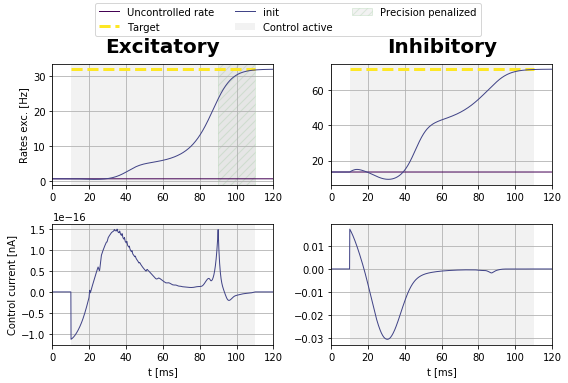

--------- 3


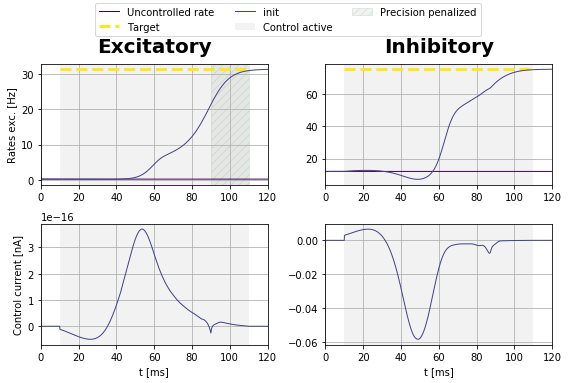

--------- 5


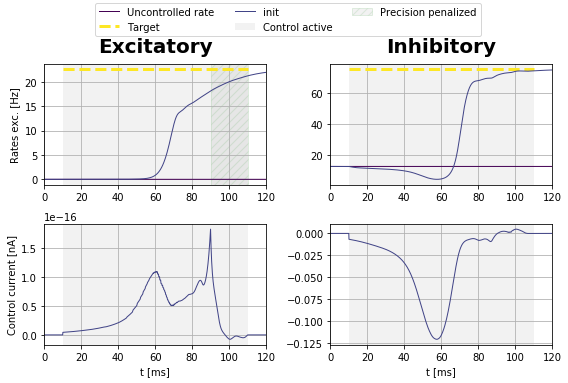

--------- 7


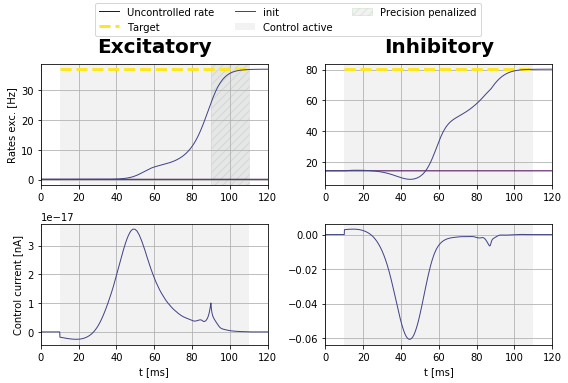

--------- 9


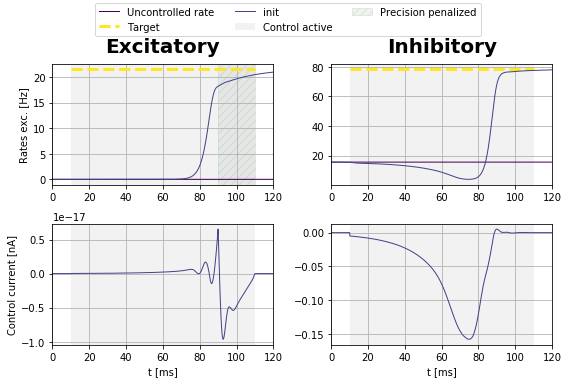

--------- 11


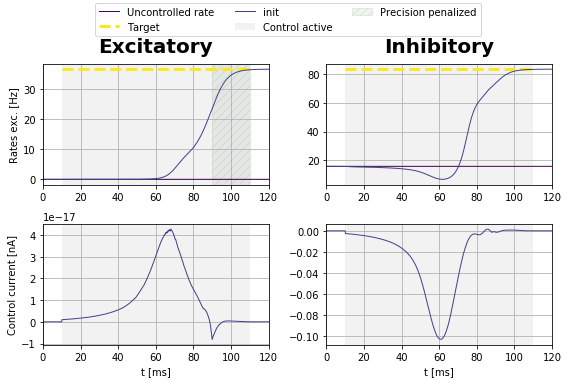

--------- 13


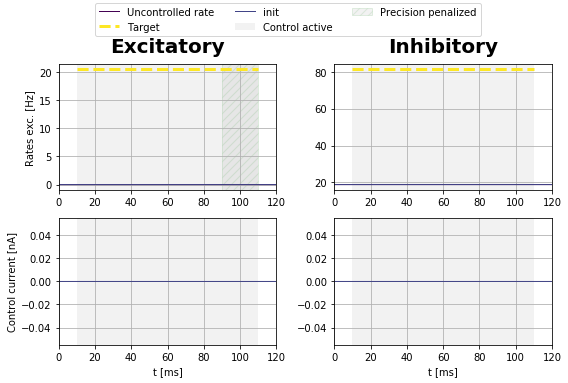

--------- 15


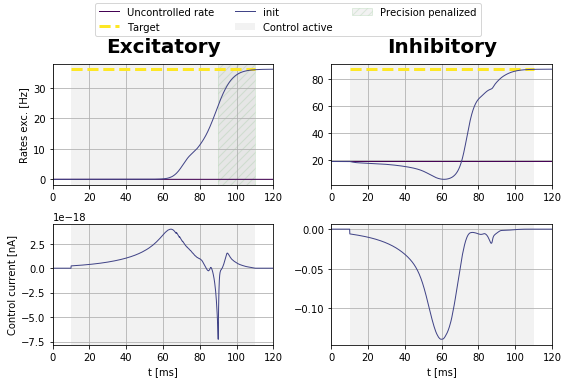

--------- 17


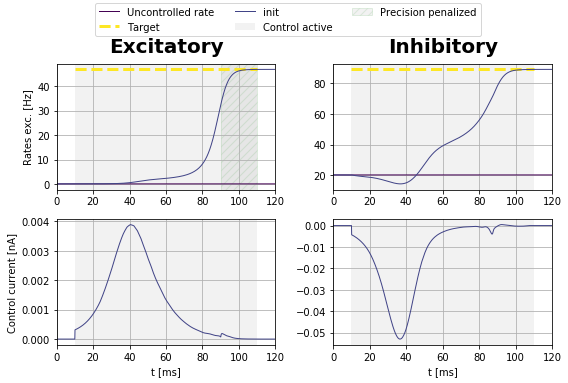

--------- 19


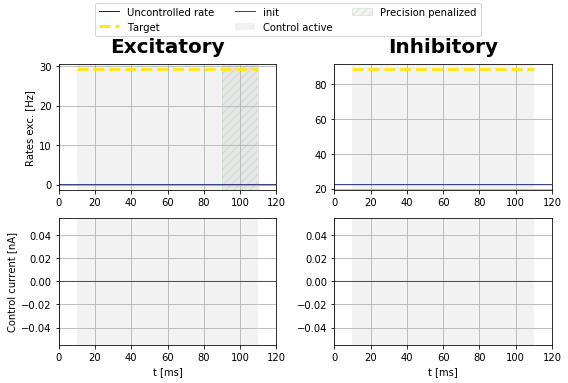

--------- 21


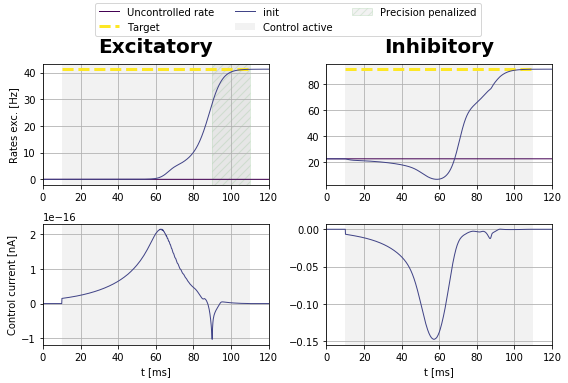

--------- 23


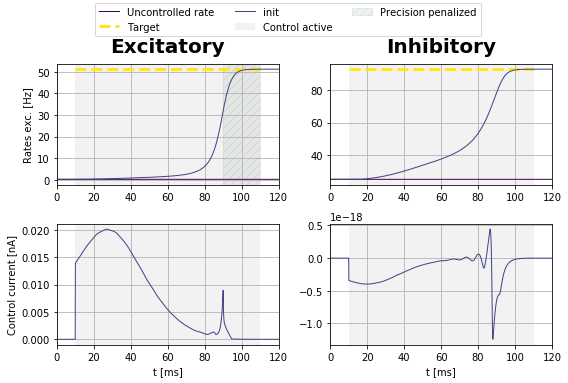

--------- 25


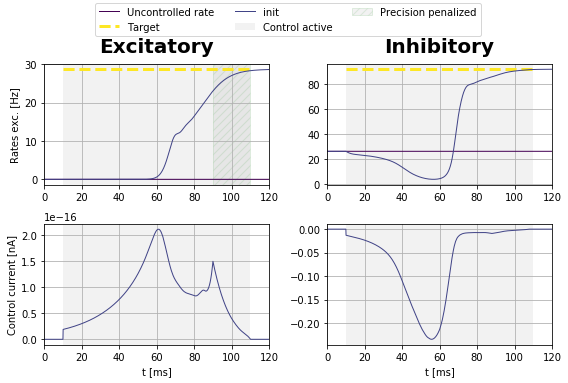

--------- 27


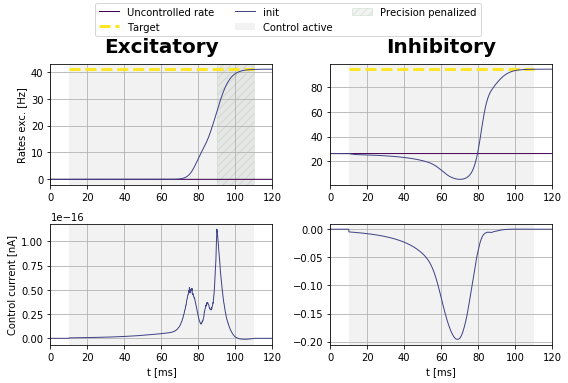

--------- 29


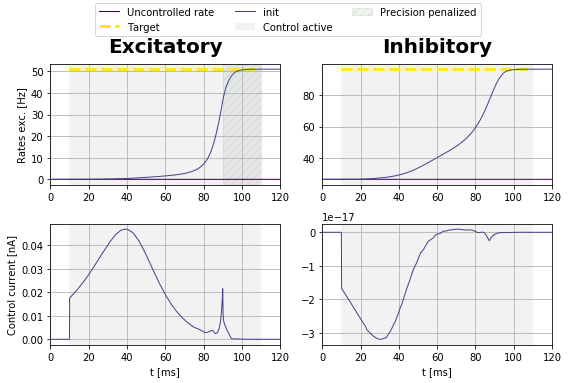

--------- 31


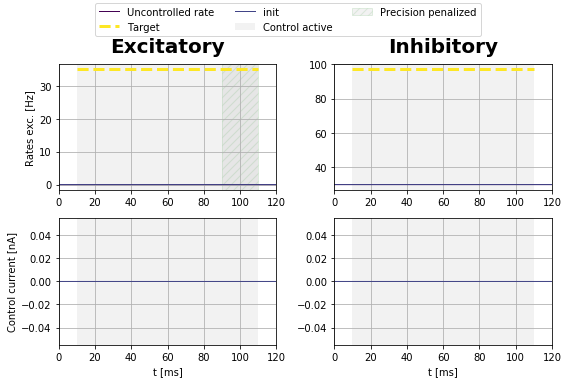

--------- 33


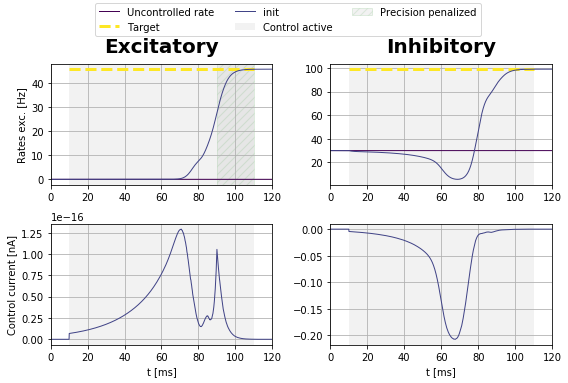

--------- 35


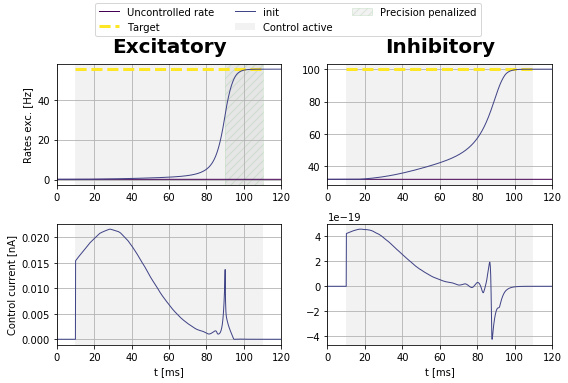

--------- 37


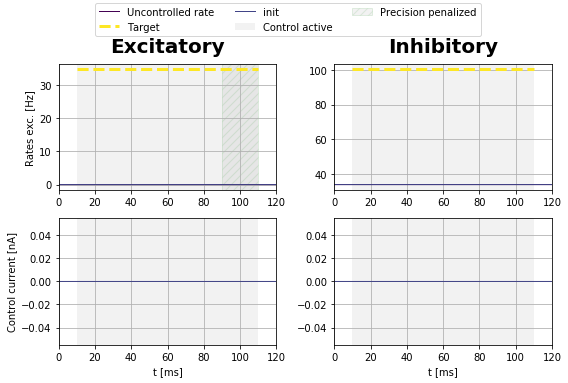

--------- 39


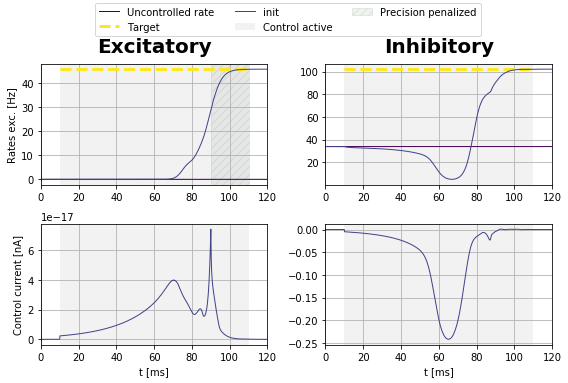

In [15]:

#plot initial guesses
for i in i_range:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()

In [16]:
found_solution = []
no_solution = []
factor_iteration = 1.
already_tried = [ [] for _ in range(len(exc)) ]

for k in range(len(i_range)**2):
    print('------------------------------------------------------------')
    print('--------------------', k)
    print('------------------------------------------------------------')
        
    print("found solution: ", found_solution)
    print("no solution: ", no_solution)
    
    if len(i_range) == len(found_solution) + len(no_solution):
        print("found solution for all parameters")
        break


    for i in i_range:
        print("------- ", i, exc[i], inh[i])        

        if np.abs(np.mean(bestState_init[i][0,0,-300:]) - target[i][0,0,-1]) < 0.1 * np.abs(
            np.mean(bestState_init[i][0,0,-100:]) - bestState_init[i][0,0,0]) and np.abs(
            np.mean(bestState_init[i][0,1,-300:]) - target[i][0,1,-1]) < 0.1 * np.abs(
            np.mean(bestState_init[i][0,1,-100:]) - bestState_init[i][0,1,0]) and np.amax(
            bestState_init[i][0,0,:]) < target[i][0,0,-1] + 1. and np.amax(
            bestState_init[i][0,1,:]) < target[i][0,1,-1] + 1.:
            # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
            #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
            if i not in found_solution:
                print("found solution for ", i)
                found_solution.append(i)
            if i in no_solution:
                no_solution.pop(no_solution.index(i))
            continue

        if len(found_solution) == 0:
            continue
            
        closest_ = getclosest(i, found_solution, exc, inh, already_tried[i])
        print("closest index ", closest_)

        weight_ = 10
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
            
        if i != 0 and closest_ != -1:
            control0 = bestControl_init[closest_][:,:,n_pre-1:-n_post+1]
            if closest_ not in already_tried[i]:
                already_tried[i].append(closest_)
                        
        if closest_ == -1:
            print("all options tried already")
            if i not in no_solution:
                no_solution.append(i)
                continue

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(100 * factor_iteration)

        weights_init[i] = cost.getParams()
        
        print("precision vars = ", prec_vars)

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        j = 1
        while cost_init[i][-j] == 0.:
            j += 1

        weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(500 * factor_iteration)

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)

------------------------------------------------------------
-------------------- 0
------------------------------------------------------------
found solution:  []
no solution:  []
-------  1 0.4250000000000001 0.3500000000000001
found solution for  1
-------  3 0.4250000000000001 0.3750000000000001
found solution for  3
-------  5 0.4000000000000001 0.40000000000000013
found solution for  5
-------  7 0.4500000000000001 0.40000000000000013
found solution for  7
-------  9 0.4000000000000001 0.42500000000000016
found solution for  9
-------  11 0.4500000000000001 0.42500000000000016
found solution for  11
-------  13 0.4000000000000001 0.4500000000000002
[1, 3, 5, 7, 9, 11] []
closest index  9
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4150.0345608400485
Gradient descend method:  None
RUN  1 , total integrated cost =  48.323867924262736
RUN  2 , total integrated cost =  42.879073257217996
RUN  3 , total 

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  42.41653607226178
RUN  100 , total integrated cost =  42.41653607226178
Improved over  100  iterations in  5.6307390999999996  seconds by  98.97792330520554  percent.
Problem in initial value trasfer:  Vmean_exc -56.62744438281019 -56.627444354284094
weight =  984.8157157551722
set cost params:  1.0 0.0 984.8157157551722
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4175.738095361468
Gradient descend method:  None
RUN  1 , total integrated cost =  4138.655613223832
RUN  2 , total integrated cost =  4131.428524766171
RUN  3 , total integrated cost =  4130.474755607246
RUN  4 , total integrated cost =  4120.727978991056
RUN  5 , total integrated cost =  4117.691599318911
RUN  6 , total integrated cost =  4117.407295229635
RUN  7 , total integrated cost =  4116.13181525728
RUN  8 , total integrated cost =  4114.877944422746
RUN  9 , total integrated cost =  4112.78901883511
RUN  10 , total integrated cost =  4112.2519830503215


ERROR:root:Problem in initial value trasfer


RUN  50 , total integrated cost =  4112.207846671659
Control only changes marginally.
RUN  50 , total integrated cost =  4112.207846671659
Improved over  50  iterations in  3.145835599999998  seconds by  1.5214136336850288  percent.
Problem in initial value trasfer:  Vmean_exc -56.631267523115895 -56.631242893632
-------  15 0.4500000000000001 0.4500000000000002
found solution for  15
-------  17 0.5000000000000002 0.4500000000000002
found solution for  17
-------  19 0.4250000000000001 0.4750000000000002
[1, 3, 5, 7, 9, 11, 15, 17] []
closest index  15
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8530.250577891176
Gradient descend method:  None
RUN  1 , total integrated cost =  8504.867682413307
RUN  2 , total integrated cost =  614.9722897453136
RUN  3 , total integrated cost =  254.6305971324636
RUN  4 , total integrated cost =  138.3834990705721
RUN  5 , total integrated cost =  101.60634248535143
RUN  

ERROR:root:Problem in initial value trasfer


RUN  100 , total integrated cost =  44.39214198507788
RUN  100 , total integrated cost =  44.39214198507788
Improved over  100  iterations in  5.5129909999999995  seconds by  99.47959158315778  percent.
Problem in initial value trasfer:  Vmean_exc -56.641854727333815 -56.64185160218169
weight =  1915.5455155557102
set cost params:  1.0 0.0 1915.5455155557102
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8500.481312064403
Gradient descend method:  None
RUN  1 , total integrated cost =  8343.067075408782
RUN  2 , total integrated cost =  8298.290056442911
RUN  3 , total integrated cost =  8273.154426915964
RUN  4 , total integrated cost =  8224.40625712138
RUN  5 , total integrated cost =  8208.589014230756
RUN  6 , total integrated cost =  8204.414256848959
RUN  7 , total integrated cost =  8065.054238183887
RUN  8 , total integrated cost =  8056.129086677835
RUN  9 , total integrated cost =  8055.690931723733
RUN  10 , total integrated cost =  8055.58749099335

ERROR:root:Problem in initial value trasfer


RUN  50 , total integrated cost =  8055.498778972421
Control only changes marginally.
RUN  52 , total integrated cost =  8055.49877897242
Improved over  52  iterations in  3.311331700000011  seconds by  5.234792204771239  percent.
Problem in initial value trasfer:  Vmean_exc -56.640551886321525 -56.640571581691674
-------  21 0.47500000000000014 0.4750000000000002
found solution for  21
-------  23 0.5250000000000001 0.4750000000000002
found solution for  23
-------  25 0.4250000000000001 0.5000000000000002
found solution for  25
-------  27 0.47500000000000014 0.5000000000000002
found solution for  27
-------  29 0.5250000000000001 0.5000000000000002
found solution for  29
-------  31 0.4500000000000001 0.5250000000000002
[1, 3, 5, 7, 9, 11, 15, 17, 21, 23, 25, 27, 29] []
closest index  25
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  360.904100819466
Gradient descend method:  None
RUN  1 , total integrated

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  26 , total integrated cost =  52.25583885964659
Improved over  26  iterations in  2.6052820999999966  seconds by  85.52085200999521  percent.
Problem in initial value trasfer:  Vmean_exc -56.66614165126491 -56.66614178161797
weight =  2342.2607816184723
set cost params:  1.0 0.0 2342.2607816184723
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12223.203522389333
Gradient descend method:  None
RUN  1 , total integrated cost =  11959.377199180431
RUN  2 , total integrated cost =  11941.750584314621
RUN  3 , total integrated cost =  11936.92828089077
RUN  4 , total integrated cost =  11931.691059003888
RUN  5 , total integrated cost =  11925.48596928286
RUN  6 , total integrated cost =  11923.825204317183
RUN  7 , total integrated cost =  11923.652353300973
RUN  8 , total integrated cost =  11923.58104222162
RUN  9 , total integrated cost =  11923.572621727586
RUN  10 , total integrated cost =  11923.57017433214
RUN  11 , tota

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  44 , total integrated cost =  11923.568649175402
Improved over  44  iterations in  3.6293397000000027  seconds by  2.451361238198217  percent.
Problem in initial value trasfer:  Vmean_exc -56.665688945644966 -56.66569815365872
-------  33 0.5000000000000002 0.5250000000000002
found solution for  33
-------  35 0.5500000000000003 0.5250000000000002
found solution for  35
-------  37 0.4500000000000001 0.5500000000000003
[1, 3, 5, 7, 9, 11, 15, 17, 21, 23, 25, 27, 29, 33, 35] []
closest index  25
set cost params:  1.0 0.0 10.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12067.527622960512
Gradient descend method:  None
RUN  1 , total integrated cost =  12019.368445257232
RUN  2 , total integrated cost =  12017.550238193673
RUN  3 , total integrated cost =  12017.483090826445
RUN  4 , total integrated cost =  12017.48291512944
RUN  5 , total integrated cost =  12017.482907679807
RUN  6 , total integrat

ERROR:root:Problem in initial value trasfer


RUN  170 , total integrated cost =  60.29593494886091
Control only changes marginally.
RUN  171 , total integrated cost =  60.29593494886091
Improved over  171  iterations in  10.719930100000013  seconds by  99.49826485785361  percent.
Problem in initial value trasfer:  Vmean_exc -56.66480135813727 -56.664801765466166
-------  39 0.5000000000000002 0.5500000000000003
found solution for  39
------------------------------------------------------------
-------------------- 1
------------------------------------------------------------
found solution:  [1, 3, 5, 7, 9, 11, 15, 17, 21, 23, 25, 27, 29, 33, 35, 39]
no solution:  []
-------  1 0.4250000000000001 0.3500000000000001
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
found solution for 

In [18]:
factor_iteration = 20
full_converge = False
conv_init = [[False]*2] * len(exc)

for i in range(len(conv_init)):
    if i not in i_range:
        conv_init[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print("------------------------------------------------")
    print('-------------------------', counter)
    
    if counter > 20:
        break
        
    print(conv_init[start_index:limit:i_stepsize])
    full_converge = True
    
    for conv in conv_init[start_index:limit:i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_init[i] == [True, True]:
            continue
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        j = 1
        while cost_init[i][-j] == 0.:
            j += 1
                       
        weight_ = (factor_we * weights_init[i][1] * cost_uncontrolled[i] / cost_init[i][-j]
                   + factor_ws * weights_init[i][2] * cost_uncontrolled[i] / cost_init[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)
            
        if j == cost_init[i].shape[0]-1:
            print("converged for ", i)
            if conv_init[i][0]:
                conv_init[i] = [True, True]
            else:
                conv_init[i] = [True, False]
            continue
    
        print("no convergence")
            
    counter += 1

------------------------------------------------
------------------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False]]
-------  1 0.4250000000000001 0.3500000000000001
weight =  17082.34841309732
set cost params:  1.0 0.0 17082.34841309732
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9815.697277286245
Gradient descend method:  None
RUN  1 , total integrated cost =  9815.697277286245


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  9815.697277286245
Improved over  1  iterations in  0.19681930000001557  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65391436897364 -56.653934089030194
converged for  1
-------  3 0.4250000000000001 0.3750000000000001
weight =  8988.067474841879
set cost params:  1.0 0.0 8988.067474841879
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9704.489187328842
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9704.489187328842
Control only changes marginally.
RUN  1 , total integrated cost =  9704.489187328842
Improved over  1  iterations in  0.20902709999998592  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65014535616288 -56.65017790766829
converged for  3
-------  5 0.4000000000000001 0.40000000000000013
weight =  2075.8903948077595
set cost params:  1.0 0.0 2075.8903948077595
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5094.835538921414
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5094.835538921414
Control only changes marginally.
RUN  1 , total integrated cost =  5094.835538921414
Improved over  1  iterations in  0.18121849999999995  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62627944114659 -56.62625606181497
converged for  5
-------  7 0.4500000000000001 0.40000000000000013
weight =  12136.416985994641
set cost params:  1.0 0.0 12136.416985994641
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13556.08813279646
Gradient descend method:  None
RUN  1 , total integrated cost =  13556.088132796458
RUN  2 , total integrated cost =  13556.088132796458
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  13556.088132796458
Improved over  2  iterations in  0.3745531999999798  seconds by  1.4210854715202004e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.6737584772694 -56.67376886220033
converged for  7
-------  9 0.4000000000000001 0.42500000000000016
weight =  1385.8152965081194
set cost params:  1.0 0.0 1385.8152965081194
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4638.928516830711
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4638.928516830711
Control only changes marginally.
RUN  1 , total integrated cost =  4638.928516830711
Improved over  1  iterations in  0.18253059999997845  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62791454593102 -56.62788734460396
converged for  9
-------  11 0.4500000000000001 0.42500000000000016
weight =  6783.711560699771
set cost params:  1.0 0.0 6783.711560699771
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13309.473795741835
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13309.473795741835
Control only changes marginally.
RUN  1 , total integrated cost =  13309.473795741835
Improved over  1  iterations in  0.2051659999999913  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67156860433412 -56.671587674058436
converged for  11
-------  13 0.4000000000000001 0.4500000000000002
weight =  999.4662451021597
set cost params:  1.0 0.0 999.4662451021597
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4173.071832766141
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4173.071832766141
Control only changes marginally.
RUN  1 , total integrated cost =  4173.071832766141
Improved over  1  iterations in  0.1741773999999907  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63128139610945 -56.63125670724592
converged for  13
-------  15 0.4500000000000001 0.4500000000000002
weight =  4740.719656107701
set cost params:  1.0 0.0 4740.719656107701
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13015.329207131403
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13015.329207131403
Control only changes marginally.
RUN  1 , total integrated cost =  13015.329207131403
Improved over  1  iterations in  0.19603499999999485  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67002797857665 -56.67004319817243
converged for  15
-------  17 0.5000000000000002 0.4500000000000002
weight =  19429.33315558334
set cost params:  1.0 0.0 19429.33315558334
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21765.643144504167
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21765.643144504167
Control only changes marginally.
RUN  1 , total integrated cost =  21765.643144504167
Improved over  1  iterations in  0.18258149999999773  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6989074433159 -56.69890803124434
converged for  17
-------  19 0.4250000000000001 0.4750000000000002
weight =  2021.898081058809
set cost params:  1.0 0.0 2021.898081058809
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8499.31321965785
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8499.31321965785
Control only changes marginally.
RUN  1 , total integrated cost =  8499.31321965785
Improved over  1  iterations in  0.1771374999999864  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64052403599127 -56.64054413933511
converged for  19
-------  21 0.47500000000000014 0.4750000000000002
weight =  6094.028531607474
set cost params:  1.0 0.0 6094.028531607474
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17066.08637926291
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17066.08637926291
Control only changes marginally.
RUN  1 , total integrated cost =  17066.08637926291
Improved over  1  iterations in  0.18674679999998034  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68738404391098 -56.68738807075025
converged for  21
-------  23 0.5250000000000001 0.4750000000000002
weight =  46018.979615659366
set cost params:  1.0 0.0 46018.979615659366
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26111.369350949797
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  26111.369350949797
Control only changes marginally.
RUN  1 , total integrated cost =  26111.369350949797
Improved over  1  iterations in  0.1950768000000096  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70352422401237 -56.70352439411907
converged for  23
-------  25 0.4250000000000001 0.5000000000000002
weight =  1626.4508607089108
set cost params:  1.0 0.0 1626.4508607089108
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8226.849061237184
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8226.849061237184
Control only changes marginally.
RUN  1 , total integrated cost =  8226.849061237184
Improved over  1  iterations in  0.1701546000000178  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.638324163914675 -56.638344413207804
converged for  25
-------  27 0.47500000000000014 0.5000000000000002
weight =  4392.6868120643585
set cost params:  1.0 0.0 4392.6868120643585
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16805.904188657685
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16805.904188657685
Control only changes marginally.
RUN  1 , total integrated cost =  16805.904188657685
Improved over  1  iterations in  0.1740643999999918  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.686318989031065 -56.686327185722405
converged for  27
-------  29 0.5250000000000001 0.5000000000000002
weight =  20228.37144158985
set cost params:  1.0 0.0 20228.37144158985
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25983.689752056667
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25983.689752056667
Control only changes marginally.
RUN  1 , total integrated cost =  25983.689752056667
Improved over  1  iterations in  0.1868131999999889  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70330203674698 -56.70330217325993
converged for  29
-------  31 0.4500000000000001 0.5250000000000002
weight =  2403.789063469191
set cost params:  1.0 0.0 2403.789063469191
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12234.590486626706
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12234.590486626706
Control only changes marginally.
RUN  1 , total integrated cost =  12234.590486626706
Improved over  1  iterations in  0.17273009999999545  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.665688945644966 -56.66569815365872
converged for  31
-------  33 0.5000000000000002 0.5250000000000002
weight =  5512.905232457515
set cost params:  1.0 0.0 5512.905232457515
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21065.31126301864
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21065.311263018637
RUN  2 , total integrated cost =  21065.311263018637
Control only changes marginally.
RUN  2 , total integrated cost =  21065.311263018637
Improved over  2  iterations in  0.35192689999999516  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.6972988566561 -56.69730098183095
converged for  33
-------  35 0.5500000000000003 0.5250000000000002
weight =  48536.1446217947
set cost params:  1.0 0.0 48536.1446217947
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30545.79964295235
Gradient descend method:  None
RUN  1 , total integrated cost =  30545.79964295235
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  30545.79964295235
Improved over  1  iterations in  0.18545420000000945  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.704437958326814 -56.70443792082199
converged for  35
-------  37 0.4500000000000001 0.5500000000000003
weight =  2041.282653216148
set cost params:  1.0 0.0 2041.282653216148
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12011.598568868421
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12011.598568868421
Control only changes marginally.
RUN  1 , total integrated cost =  12011.598568868421
Improved over  1  iterations in  0.22227870000000394  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66435007721458 -56.6643585477666
converged for  37
-------  39 0.5000000000000002 0.5500000000000003
weight =  4620.938940539893
set cost params:  1.0 0.0 4620.938940539893
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20836.35382876745
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  20836.35382876745
Control only changes marginally.
RUN  1 , total integrated cost =  20836.35382876745
Improved over  1  iterations in  0.18433659999999463  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69682635673682 -56.696828440843
converged for  39
------------------------------------------------
------------------------- 1
[[True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False]]
-------  1 0.4250000000000001 0.3500000000000001
weight =  17082.348413097323
set cost params:  1.0 0.0 17082.348413097323
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9815.697277286246
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9815.697277286246
Control only changes marginally.
RUN  1 , total integrated cost =  9815.697277286246
Improved over  1  iterations in  0.20470489999999586  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65391436897364 -56.653934089030194
converged for  1
-------  3 0.4250000000000001 0.3750000000000001
weight =  8988.067474841937
set cost params:  1.0 0.0 8988.067474841937
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9704.489187328903
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9704.489187328903
Control only changes marginally.
RUN  1 , total integrated cost =  9704.489187328903
Improved over  1  iterations in  0.18456409999998868  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65014535616288 -56.65017790766829
converged for  3
-------  5 0.4000000000000001 0.40000000000000013
weight =  2075.8903948077595
set cost params:  1.0 0.0 2075.8903948077595
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5094.835538921414
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5094.835538921414
Control only changes marginally.
RUN  1 , total integrated cost =  5094.835538921414
Improved over  1  iterations in  0.18661399999999162  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62627944114659 -56.62625606181497
converged for  5
-------  7 0.4500000000000001 0.40000000000000013
weight =  12136.416985994718
set cost params:  1.0 0.0 12136.416985994718
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13556.088132796544
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13556.088132796544
Control only changes marginally.
RUN  1 , total integrated cost =  13556.088132796544
Improved over  1  iterations in  0.18224779999999896  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6737584772694 -56.67376886220033
no convergence
-------  9 0.4000000000000001 0.42500000000000016
weight =  1385.8152965081197
set cost params:  1.0 0.0 1385.8152965081197
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4638.9285168307115
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4638.9285168307115
Control only changes marginally.
RUN  1 , total integrated cost =  4638.9285168307115
Improved over  1  iterations in  0.18323380000001066  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62791454593102 -56.62788734460396
converged for  9
-------  11 0.4500000000000001 0.42500000000000016
weight =  6783.71156070005
set cost params:  1.0 0.0 6783.71156070005
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13309.473795742366
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13309.473795742366
Control only changes marginally.
RUN  1 , total integrated cost =  13309.473795742366
Improved over  1  iterations in  0.18080530000000294  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67156860433412 -56.671587674058436
converged for  11
-------  13 0.4000000000000001 0.4500000000000002
weight =  999.4662451021599
set cost params:  1.0 0.0 999.4662451021599
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4173.071832766142
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4173.071832766142
Control only changes marginally.
RUN  1 , total integrated cost =  4173.071832766142
Improved over  1  iterations in  0.17404369999999858  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63128139610945 -56.63125670724592
converged for  13
-------  15 0.4500000000000001 0.4500000000000002
weight =  4740.719656107701
set cost params:  1.0 0.0 4740.719656107701
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13015.329207131403
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13015.329207131403
Control only changes marginally.
RUN  1 , total integrated cost =  13015.329207131403
Improved over  1  iterations in  0.19425050000000965  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67002797857665 -56.67004319817243
converged for  15
-------  17 0.5000000000000002 0.4500000000000002
weight =  19429.333155583343
set cost params:  1.0 0.0 19429.333155583343
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21765.64314450417
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21765.64314450417
Control only changes marginally.
RUN  1 , total integrated cost =  21765.64314450417
Improved over  1  iterations in  0.18211169999997878  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6989074433159 -56.69890803124434
converged for  17
-------  19 0.4250000000000001 0.4750000000000002
weight =  2021.8980810588278
set cost params:  1.0 0.0 2021.8980810588278
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8499.313219657928
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8499.313219657928
Control only changes marginally.
RUN  1 , total integrated cost =  8499.313219657928
Improved over  1  iterations in  0.1797347999999772  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64052403599127 -56.64054413933511
converged for  19
-------  21 0.47500000000000014 0.4750000000000002
weight =  6094.028531607486
set cost params:  1.0 0.0 6094.028531607486
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17066.086379262943
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17066.086379262943
Control only changes marginally.
RUN  1 , total integrated cost =  17066.086379262943
Improved over  1  iterations in  0.1794238999999891  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68738404391098 -56.68738807075025
converged for  21
-------  23 0.5250000000000001 0.4750000000000002
weight =  46018.97961565953
set cost params:  1.0 0.0 46018.97961565953
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26111.36935094989
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  26111.36935094989
Control only changes marginally.
RUN  1 , total integrated cost =  26111.36935094989
Improved over  1  iterations in  0.1954104000000143  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70352422401237 -56.70352439411907
converged for  23
-------  25 0.4250000000000001 0.5000000000000002
weight =  1626.4508607089106
set cost params:  1.0 0.0 1626.4508607089106
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8226.849061237182
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8226.849061237182
Control only changes marginally.
RUN  1 , total integrated cost =  8226.849061237182
Improved over  1  iterations in  0.17073649999997542  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.638324163914675 -56.638344413207804
converged for  25
-------  27 0.47500000000000014 0.5000000000000002
weight =  4392.686812135066
set cost params:  1.0 0.0 4392.686812135066
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16805.90418892214
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16805.90418892214
Control only changes marginally.
RUN  1 , total integrated cost =  16805.90418892214
Improved over  1  iterations in  0.18559069999997746  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.686318989031065 -56.686327185722405
converged for  27
-------  29 0.5250000000000001 0.5000000000000002
weight =  20228.371441589854
set cost params:  1.0 0.0 20228.371441589854
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25983.68975205667
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25983.68975205667
Control only changes marginally.
RUN  1 , total integrated cost =  25983.68975205667
Improved over  1  iterations in  0.19026600000000826  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70330203674698 -56.70330217325993
converged for  29
-------  31 0.4500000000000001 0.5250000000000002
weight =  2403.789063470126
set cost params:  1.0 0.0 2403.789063470126
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12234.590486631432
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12234.590486631432
Control only changes marginally.
RUN  1 , total integrated cost =  12234.590486631432
Improved over  1  iterations in  0.1819911999999988  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.665688945644966 -56.66569815365872
converged for  31
-------  33 0.5000000000000002 0.5250000000000002
weight =  5512.905232457547
set cost params:  1.0 0.0 5512.905232457547
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21065.311263018757
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21065.311263018757
Control only changes marginally.
RUN  1 , total integrated cost =  21065.311263018757
Improved over  1  iterations in  0.20320250000000328  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6972988566561 -56.69730098183095
no convergence
-------  35 0.5500000000000003 0.5250000000000002
weight =  48536.1446217947
set cost params:  1.0 0.0 48536.1446217947
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30545.79964295235
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  30545.79964295235
Control only changes marginally.
RUN  1 , total integrated cost =  30545.79964295235
Improved over  1  iterations in  0.20989369999998075  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.704437958326814 -56.70443792082199
converged for  35
-------  37 0.4500000000000001 0.5500000000000003
weight =  2041.2826532168087
set cost params:  1.0 0.0 2041.2826532168087
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12011.598568872283
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12011.598568872283
Control only changes marginally.
RUN  1 , total integrated cost =  12011.598568872283
Improved over  1  iterations in  0.1813847000000237  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66435007721458 -56.6643585477666
converged for  37
-------  39 0.5000000000000002 0.5500000000000003
weight =  4620.938940539943
set cost params:  1.0 0.0 4620.938940539943
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20836.35382876767
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  20836.35382876767
Control only changes marginally.
RUN  1 , total integrated cost =  20836.35382876767
Improved over  1  iterations in  0.17760140000001456  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69682635673682 -56.696828440843
converged for  39
------------------------------------------------
------------------------- 2
[[True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True]]
-------  1 0.4250000000000001 0.3500000000000001
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
weight =  12136.41698599472
set cost params:  1.0 0.0 12136.41698599472
interpolate adjoint :  True True True
RUN  0 , total i

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13556.088132796545
Control only changes marginally.
RUN  1 , total integrated cost =  13556.088132796545
Improved over  1  iterations in  0.18762060000000247  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6737584772694 -56.67376886220033
converged for  7
-------  9 0.4000000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  21 0.47500000000000014 0.4750000000000002
-------  23 0.5250000000000001 0.4750000000000002
-------  25 0.4250000000000001 0.5000000000000002
-------  27 0.47500000000000014 0.5000000000000002
-------  29 0.5250000000000001 0.5000000000000002
-------  31 0.4500000000000001 0.5250000000000002
-------  33 0.5000000000000002 0.5250000000000002
weight =  5512.905232457548
s

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21065.31126301876
Control only changes marginally.
RUN  1 , total integrated cost =  21065.31126301876
Improved over  1  iterations in  0.20008109999997714  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6972988566561 -56.69730098183095
converged for  33
-------  35 0.5500000000000003 0.5250000000000002
-------  37 0.4500000000000001 0.5500000000000003
-------  39 0.5000000000000002 0.5500000000000003
------------------------------------------------
------------------------- 3
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
full convergence


In [18]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [19]:
factor_iteration = 20
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 20:
        break
    
    print(conv_0[::i_stepsize])
    full_converge = True
    
    for conv in conv_0[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5901.3951792054
Control only changes marginally.
RUN  1 , total integrated cost =  5901.3951792054
Improved over  1  iterations in  0.35463759999998956  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6262228967628 -56.62623400496918
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  3024.3584928044625
set cost params:  1.0 0.0 3024.3584928044625
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5536.877001358082
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5536.877001358082
Control only changes marginally.
RUN  1 , total integrated cost =  5536.877001358082
Improved over  1  iterations in  0.39315399999998135  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62584324059247 -56.625827187418416
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  24836.534407251627
set cost params:  1.0 0.0 24836.534407251627
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13601.718975697391
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13601.718975697391
Control only changes marginally.
RUN  1 , total integrated cost =  13601.718975697391
Improved over  1  iterations in  0.384135399999991  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67584963929095 -56.67585512803304
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  5082.979694077504
set cost params:  1.0 0.0 5082.979694077504
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.220105413242
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.220105413242
Control only changes marginally.
RUN  1 , total integrated cost =  9437.220105413242
Improved over  1  iterations in  0.39882710000000543  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64642234113263 -56.646468416066675
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  37522.48249438792
set cost params:  1.0 0.0 37522.48249438792
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17550.680085304033
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17550.680085304033
Control only changes marginally.
RUN  1 , total integrated cost =  17550.680085304033
Improved over  1  iterations in  0.37986380000000963  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6905742295605 -56.690577150211595
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  3379.5822836985494
set cost params:  1.0 0.0 3379.5822836985494
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9108.761257341066
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9108.761257341066
Control only changes marginally.
RUN  1 , total integrated cost =  9108.761257341066
Improved over  1  iterations in  0.3377094999999599  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644048962615685 -56.6440888614703
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  15230.464175131201
set cost params:  1.0 0.0 15230.464175131201
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17570.046554272652
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17570.046554272652
Control only changes marginally.
RUN  1 , total integrated cost =  17570.046554272652
Improved over  1  iterations in  0.3990112000000181  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.689469567323506 -56.68947236062619
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  2447.226984964249
set cost params:  1.0 0.0 2447.226984964249
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8792.582684847264
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8792.582684847264
Control only changes marginally.
RUN  1 , total integrated cost =  8792.582684847264
Improved over  1  iterations in  0.3261092999999846  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64194664842107 -56.64197918036114
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  8922.476022870595
set cost params:  1.0 0.0 8922.476022870595
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17338.954665545665
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17338.954665545665
Control only changes marginally.
RUN  1 , total integrated cost =  17338.954665545665
Improved over  1  iterations in  0.3524552000000085  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68841711056593 -56.68842007797163
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  731.7493339539174
set cost params:  1.0 0.0 731.7493339539174
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3666.149128189625
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3666.149128189625
Control only changes marginally.
RUN  1 , total integrated cost =  3666.149128189625
Improved over  1  iterations in  0.3405035999999768  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63750134583749 -56.63748722031219
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  3462.494613799729
set cost params:  1.0 0.0 3462.494613799729
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12734.438628339765
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12734.438628339765
Control only changes marginally.
RUN  1 , total integrated cost =  12734.438628339765
Improved over  1  iterations in  0.3330468000000337  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66829382600908 -56.66831126824242
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  10759.009724912565
set cost params:  1.0 0.0 10759.009724912565
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21563.17339146034
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21563.17339146034
Control only changes marginally.
RUN  1 , total integrated cost =  21563.17339146034
Improved over  1  iterations in  0.337782500000003  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69835503200788 -56.69835618541601
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  455.56916852561795
set cost params:  1.0 0.0 455.56916852561795
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2974.452541430177
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2974.452541430177
Control only changes marginally.
RUN  1 , total integrated cost =  2974.452541430177
Improved over  1  iterations in  0.344188900000006  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.648151449872664 -56.648188681921845
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  2769.8364813045155
set cost params:  1.0 0.0 2769.8364813045155
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12475.180672257013
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12475.180672257013
Control only changes marginally.
RUN  1 , total integrated cost =  12475.180672257013
Improved over  1  iterations in  0.3321442000000161  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66677928940908 -56.66679685883752
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  7294.105296180297
set cost params:  1.0 0.0 7294.105296180297
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21310.171221283337
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21310.171221283337
Control only changes marginally.
RUN  1 , total integrated cost =  21310.171221283337
Improved over  1  iterations in  0.348651899999993  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.697802287500494 -56.697804094588946
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  1332.905024786924
set cost params:  1.0 0.0 1332.905024786924
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7972.336008438606
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7972.336008438606
Control only changes marginally.
RUN  1 , total integrated cost =  7972.336008438606
Improved over  1  iterations in  0.33445159999996577  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63606067870955 -56.63608477434123
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  4002.701047229695
set cost params:  1.0 0.0 4002.701047229695
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.080153989496
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16564.080153989496
Control only changes marginally.
RUN  1 , total integrated cost =  16564.080153989496
Improved over  1  iterations in  0.3325848999999721  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68563125475033 -56.68563456977638
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  8937.36559136449
set cost params:  1.0 0.0 8937.36559136449
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25756.808386230256
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25756.808386230256
Control only changes marginally.
RUN  1 , total integrated cost =  25756.808386230256
Improved over  1  iterations in  0.36501590000000306  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70307245556776 -56.70307275856366
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
weight =  1169.2924065670484
set cost params:  1.0 0.0 1169.2924065670484
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7735.052576513034
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7735.052576513034
Control only changes marginally.
RUN  1 , total integrated cost =  7735.052576513034
Improved over  1  iterations in  0.3550352999999973  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63632530048785 -56.63632139208764
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  3573.4946563219482
set cost params:  1.0 0.0 3573.4946563219482
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.055623892427
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16340.055623892427
Control only changes marginally.
RUN  1 , total integrated cost =  16340.055623892427
Improved over  1  iterations in  0.36004400000001624  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.684815788987436 -56.6848163185068
converged for  38
--------------- 1
[[True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5901.3951792054
Control only changes marginally.
RUN  1 , total integrated cost =  5901.3951792054
Improved over  1  iterations in  0.3555616999999529  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6262228967628 -56.62623400496918
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  3024.358492804539
set cost params:  1.0 0.0 3024.358492804539
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5536.877001358217
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5536.877001358217
Control only changes marginally.
RUN  1 , total integrated cost =  5536.877001358217
Improved over  1  iterations in  0.3154109000000176  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62584324059247 -56.625827187418416
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  24836.534407251627
set cost params:  1.0 0.0 24836.534407251627
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13601.718975697391
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13601.718975697391
Control only changes marginally.
RUN  1 , total integrated cost =  13601.718975697391
Improved over  1  iterations in  0.3528956999999764  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67584963929095 -56.67585512803304
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  5082.9796940783235
set cost params:  1.0 0.0 5082.9796940783235
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.220105414715
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.220105414715
Control only changes marginally.
RUN  1 , total integrated cost =  9437.220105414715
Improved over  1  iterations in  0.40091300000000274  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64642234113263 -56.646468416066675
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  37522.48249438793
set cost params:  1.0 0.0 37522.48249438793
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17550.680085304037
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17550.680085304037
Control only changes marginally.
RUN  1 , total integrated cost =  17550.680085304037
Improved over  1  iterations in  0.3744183000000021  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6905742295605 -56.690577150211595
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  3379.582283698549
set cost params:  1.0 0.0 3379.582283698549
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9108.761257341064
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9108.761257341064
Control only changes marginally.
RUN  1 , total integrated cost =  9108.761257341064
Improved over  1  iterations in  0.33152589999997417  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644048962615685 -56.6440888614703
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  15230.464175131203
set cost params:  1.0 0.0 15230.464175131203
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17570.046554272656
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17570.046554272656
Control only changes marginally.
RUN  1 , total integrated cost =  17570.046554272656
Improved over  1  iterations in  0.3512720999999601  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.689469567323506 -56.68947236062619
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  2447.2269849699355
set cost params:  1.0 0.0 2447.2269849699355
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8792.582684867302
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8792.582684867302
Control only changes marginally.
RUN  1 , total integrated cost =  8792.582684867302
Improved over  1  iterations in  0.385492499999998  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64194664842107 -56.64197918036114
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  8922.476022870595
set cost params:  1.0 0.0 8922.476022870595
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17338.954665545665
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17338.954665545665
Control only changes marginally.
RUN  1 , total integrated cost =  17338.954665545665
Improved over  1  iterations in  0.36491789999996627  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68841711056593 -56.68842007797163
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  731.7493339539174
set cost params:  1.0 0.0 731.7493339539174
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3666.149128189625
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3666.149128189625
Control only changes marginally.
RUN  1 , total integrated cost =  3666.149128189625
Improved over  1  iterations in  0.35618870000001834  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63750134583749 -56.63748722031219
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  3462.4946137997285
set cost params:  1.0 0.0 3462.4946137997285
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12734.438628339763
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12734.438628339763
Control only changes marginally.
RUN  1 , total integrated cost =  12734.438628339763
Improved over  1  iterations in  0.3463346999999999  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66829382600908 -56.66831126824242
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  10759.009724912585
set cost params:  1.0 0.0 10759.009724912585
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21563.173391460376
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21563.173391460376
Control only changes marginally.
RUN  1 , total integrated cost =  21563.173391460376
Improved over  1  iterations in  0.33694630000002235  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69835503200788 -56.69835618541601
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  455.569168525618
set cost params:  1.0 0.0 455.569168525618
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2974.4525414301775
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2974.4525414301775
Control only changes marginally.
RUN  1 , total integrated cost =  2974.4525414301775
Improved over  1  iterations in  0.3221699000000058  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.648151449872664 -56.648188681921845
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  2769.8364813045155
set cost params:  1.0 0.0 2769.8364813045155
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12475.180672257013
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12475.180672257013
Control only changes marginally.
RUN  1 , total integrated cost =  12475.180672257013
Improved over  1  iterations in  0.3749578000000042  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66677928940908 -56.66679685883752
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  7294.105296180297
set cost params:  1.0 0.0 7294.105296180297
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21310.171221283337
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21310.171221283337
Control only changes marginally.
RUN  1 , total integrated cost =  21310.171221283337
Improved over  1  iterations in  0.3531908000000499  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.697802287500494 -56.697804094588946
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  1332.905024786924
set cost params:  1.0 0.0 1332.905024786924
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7972.336008438606
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7972.336008438606
Control only changes marginally.
RUN  1 , total integrated cost =  7972.336008438606
Improved over  1  iterations in  0.391526400000032  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63606067870955 -56.63608477434123
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  4002.7010472296947
set cost params:  1.0 0.0 4002.7010472296947
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.080153989493
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16564.080153989493
Control only changes marginally.
RUN  1 , total integrated cost =  16564.080153989493
Improved over  1  iterations in  0.3574102000000039  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68563125475033 -56.68563456977638
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  8937.36559147698
set cost params:  1.0 0.0 8937.36559147698
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25756.808386548466
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25756.808386548466
Control only changes marginally.
RUN  1 , total integrated cost =  25756.808386548466
Improved over  1  iterations in  0.3353567000000339  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70307245556776 -56.70307275856366
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
weight =  1169.2924065670484
set cost params:  1.0 0.0 1169.2924065670484
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7735.052576513034
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7735.052576513034
Control only changes marginally.
RUN  1 , total integrated cost =  7735.052576513034
Improved over  1  iterations in  0.3118077000000312  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63632530048785 -56.63632139208764
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  3573.494656321952
set cost params:  1.0 0.0 3573.494656321952
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.055623892444
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16340.055623892444
Control only changes marginally.
RUN  1 , total integrated cost =  16340.055623892444
Improved over  1  iterations in  0.3364927999999736  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.684815788987436 -56.6848163185068
converged for  38
--------------- 2
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tru

In [20]:
"""
for i in i_range_0:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
"""

'\nfor i in i_range_0:\n    \n    aln.params.ext_exc_current = exc[i] * 5.\n    aln.params.ext_inh_current = inh[i] * 5.\n\n    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],\n        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,\n        dur_pre, dur_post, initVars[i], target[i], \'\', filename_ = \'\', transition_time_ = trans_time,\n        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)\n'

In [21]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

file found


In [22]:
factor_iteration = 20
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 20:
        break
    
    print(conv_1[::i_stepsize])
    full_converge = True
    
    for conv in conv_1[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_1[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.1130619408485818
Control only changes marginally.
RUN  1 , total integrated cost =  1.1130619408485818
Improved over  1  iterations in  0.35675229999998237  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.627622079911795 -56.62762204082369
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  196.56205266127185
Gradient descend method:  None
RUN  1 , total integrated cost =  2.6686120654920638
RUN  2 , total integrated cost =  2.379022690798104
RUN  3 , total integrated cost =  2.27260217312955
RUN  4 , total integrated cost =  2.1883388268506274
RUN  5 , total integrated cost =  2.1404913649057487
RUN  6 , total integrated cost =  2.0922215648075873
RUN  7 , total integrated cost =  2.06525148740787
RUN  8 , total integrated cost =  2.031963117291249
RUN  9 , total integrated cost =  2.017429858554015
RUN  10 ,

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  474 , total integrated cost =  1.9408895129815709
Improved over  474  iterations in  48.51870389999999  seconds by  99.01258178437614  percent.
Problem in initial value trasfer:  Vmean_exc -56.625517194834 -56.62551716361398
no convergence
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.5840960208663505
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.5840960208663505
Control only changes marginally.
RUN  1 , total integrated cost =  0.5840960208663505
Improved over  1  iterations in  0.29561899999998786  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67605687511343 -56.67605688554732
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  295.05332029566523
Gradient descend method:  None
RUN  1 , total integrated cost =  2.220964128914292
RUN  2 , total integrated cost =  2.2111647055565204
RUN  3 , total integrated cost =  2.1854771773427863
RUN  4 , total integrated cost =  2.171766366494248
RUN  5 , total integrated cost =  2.169704499988429
RUN  6 , total integrated cost =  2.1648452703205816
RUN  7 , total integrated cost =  2.161886366577831
RUN  8 , total integrated cost =  2.158171954002463
RUN  9 , total integrated cost =  2.1556076987451074
RUN  10

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1530 , total integrated cost =  2.008620128059506
Improved over  1530  iterations in  162.68170309999994  seconds by  99.31923486709225  percent.
Problem in initial value trasfer:  Vmean_exc -56.649099257345156 -56.64909897314752
no convergence
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.4960431442964074
Gradient descend method:  None
RUN  1 , total integrated cost =  0.4960431442964074
Control only changes marginally.
RUN  1 , total integrated cost =  0.4960431442964074
Improved over  1  iterations in  0.2862202999999681  seconds by  0.0  percent.
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.9010496552271876
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.9010496552271876
Control only changes marginally.
RUN  1 , total integrated cost =  2.9010496552271876
Improved over  1  iterations in  0.27471730000002026  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64651070007215 -56.6465108539142
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.2172055882790564
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.2172055882790564
Control only changes marginally.
RUN  1 , total integrated cost =  1.2172055882790564
Improved over  1  iterations in  0.3164911999999731  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68955933468049 -56.68955928510748
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  173.22327148904148
Gradient descend method:  None
RUN  1 , total integrated cost =  3.8999751254501267
RUN  2 , total integrated cost =  3.7891282617703363
RUN  3 , total integrated cost =  3.7675192307554046
RUN  4 , total integrated cost =  3.7623177952746287
RUN  5 , total integrated cost =  3.7599317760669186
RUN  6 , total integrated cost =  3.759056972071838
RUN  7 , total integrated cost =  3.7584164467548953
RUN  8 , total integrated cost =  3.7581896358787352
RUN  9 , total integrated cost =  3.757750626019341
RUN 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  38 , total integrated cost =  3.7570124043870066
Improved over  38  iterations in  4.2662156000000095  seconds by  97.8311156624099  percent.
Problem in initial value trasfer:  Vmean_exc -56.64410941515465 -56.644109771253696
no convergence
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.0395466114762124
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.0395466114762124
Control only changes marginally.
RUN  1 , total integrated cost =  2.0395466114762124
Improved over  1  iterations in  0.2866212999999789  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.688516522153115 -56.68851644631178
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.8756585401864
Gradient descend method:  None
RUN  1 , total integrated cost =  9.203698017102798
RUN  2 , total integrated cost =  8.986284834757349
RUN  3 , total integrated cost =  8.742549333897571
RUN  4 , total integrated cost =  8.6115680633248
RUN  5 , total integrated cost =  8.442062670228797
RUN  6 , total integrated cost =  8.333153048314585
RUN  7 , total integrated cost =  8.175730116959734
RUN  8 , total integrated cost =  8.054027696975735
RUN  9 , total integrated cost =  7.846413342542212
RUN  10 , tota

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1361 , total integrated cost =  5.063032015374245
Improved over  1361  iterations in  110.4596454  seconds by  73.17692516743182  percent.
Problem in initial value trasfer:  Vmean_exc -56.63366040031188 -56.633660128435665
no convergence
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.9083448513615044
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.9083448513615044
Control only changes marginally.
RUN  1 , total integrated cost =  3.9083448513615044
Improved over  1  iterations in  0.217852799999946  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.669066538304904 -56.6690666766907
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  253.60372369806356
Gradient descend method:  None
RUN  1 , total integrated cost =  2.227687354594262
RUN  2 , total integrated cost =  2.207497560206769
RUN  3 , total integrated cost =  2.201268186645364
RUN  4 , total integrated cost =  2.193958640816047
RUN  5 , total integrated cost =  2.1885576470178774
RUN  6 , total integrated cost =  2.1828398780933305
RUN  7 , total integrated cost =  2.1798700705829197
RUN  8 , total integrated cost =  2.1769542754644746
RUN  9 , total integrated cost =  2.1747686281683833
RUN  10

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  653 , total integrated cost =  2.141990243418235
Improved over  653  iterations in  50.361973499999976  seconds by  99.15537902512486  percent.
Problem in initial value trasfer:  Vmean_exc -56.69838768947436 -56.698387706683306
no convergence
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.538237043140779
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  6.538237043140779
Control only changes marginally.
RUN  1 , total integrated cost =  6.538237043140779
Improved over  1  iterations in  0.21620289999998477  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65188295386897 -56.65188294042322
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  210.43050421917496
Gradient descend method:  None
RUN  1 , total integrated cost =  4.852763761098478
RUN  2 , total integrated cost =  4.820377266090527
RUN  3 , total integrated cost =  4.811624465676677
RUN  4 , total integrated cost =  4.808921857694653
RUN  5 , total integrated cost =  4.8076099178893825
RUN  6 , total integrated cost =  4.806169273194303
RUN  7 , total integrated cost =  4.805291579721657
RUN  8 , total integrated cost =  4.804403131872621
RUN  9 , total integrated cost =  4.803570482894639
RUN  10 , t

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1026 , total integrated cost =  4.71641169599462
Improved over  1026  iterations in  89.62216869999997  seconds by  97.7586844105633  percent.
Problem in initial value trasfer:  Vmean_exc -56.667578217291954 -56.667578587873436
no convergence
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3.067679743834042
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3.067679743834042
Control only changes marginally.
RUN  1 , total integrated cost =  3.067679743834042
Improved over  1  iterations in  0.2590910000000122  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69785465082642 -56.69785468608287
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.116930096652698
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  6.116930096652698
Control only changes marginally.
RUN  1 , total integrated cost =  6.116930096652698
Improved over  1  iterations in  0.21355909999999767  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63789876455007 -56.637898967355575
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.152601720710101
Gradient descend method:  None
RUN  1 , total integrated cost =  4.152601720710101
Control only changes marginally.
RUN  1 , total integrated cost =  4.152601720710101
Improved over  1  iterations in  0.25478980000002593  seconds by  0.0  percent.
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  477.6187383450294
Gradient descend method:  None
RUN  1 , total integrated cost =  3.2919998

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  775 , total integrated cost =  2.948382264592606
Improved over  775  iterations in  62.06074309999997  seconds by  99.3826912497594  percent.
Problem in initial value trasfer:  Vmean_exc -56.70308038116716 -56.703080364178255
no convergence
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.631981683771573
Gradient descend method:  None
RUN  1 , total integrated cost =  6.631981683771573
Control only changes marginally.
RUN  1 , total integrated cost =  6.631981683771573
Improved over  1  iterations in  0.2640724999999975  seconds by  0.0  percent.
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  80.33190348822151
Gradient descend method:  None
RUN  1 , total integrated cost =  5.456390656235598
RUN  2 , total integrated cost =

KeyboardInterrupt: 